In [1]:
%matplotlib inline
import random
import os, sys, time
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils.bosch_functions as bosch_functions
from utils.wrapped_xgboost import xgboost_classifier
from utils.validation_tools import score_MCC, MCC, create_validation_index
from utils.models import CombinedModel
from utils.data_munge import remove_single_value_columns

data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'

sample_submission_file   = 'sample_submission.csv'


start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'
nan_fill_value = -2.


### section to select data (rows-wise) based on the start_time

In [2]:
bin_num = 1 ## number of bins to separate data by start_time
tmp_train, tmp_test, bins, bin_names = bosch_functions.create_grouped_index_df(bin_num)

data loading takes  57.8  seconds.


In [4]:
print tmp_train.shape
tmp_train.head()

(1183747, 3)


,L0_S0_D1,time_window_num,row_num
Id,,,
4,82.24,0,1
6,NaN,NaN,2
7,1618.70,0,3
9,1149.20,0,4
11,602.64,0,5


In [22]:
nrows = 50000
sampled_index = random.sample(tmp_train.index.tolist(), nrows)
skipped_train_row_num = tmp_train.loc[~tmp_train.index.isin(sampled_index), 'row_num'].tolist()

In [25]:
print tmp_train.shape[0] - len(skipped_train_row_num)

50000


In [26]:
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),  skiprows=skipped_train_row_num,  index_col='Id')
train_dat = pd.read_csv(join(data_path, train_date_file), skiprows=skipped_train_row_num,  index_col='Id')
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))

finish loading date using 25.0 seconds


In [28]:
print train_num.shape, train_dat.shape

(50000, 969) (50000, 1156)


In [4]:
'''
def creat_non_selected_window_num(bin_num, select_bin = '3'):
    none_selected_window_num = [np.NaN]
    for i in range(bin_num):
        if str(i) != select_bin:
            none_selected_window_num.append(str(i))
    return none_selected_window_num
    
none_selected_window_num = creat_non_selected_window_num(bin_num, '0')
skipped_test_row_num = tmp_test.loc[tmp_test['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
skipped_train_row_num = tmp_train.loc[tmp_train['time_window_num'].isin(none_selected_window_num), 'row_num'].tolist()
print tmp_train.shape, tmp_test.shape, len(skipped_train_row_num), len(skipped_test_row_num)
'''

In [27]:
'''
## select all the numerical columns and try to use LR
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),  skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)
train_dat = pd.read_csv(join(data_path, train_date_file), skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)
train_cat = pd.read_csv(join(data_path, train_cat_file),  skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))
'''

"\n## select all the numerical columns and try to use LR\nstart_time = time.time()\ntrain_num = pd.read_csv(join(data_path, train_num_file),  skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)\ntrain_dat = pd.read_csv(join(data_path, train_date_file), skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)\ntrain_cat = pd.read_csv(join(data_path, train_cat_file),  skiprows=skipped_train_row_num,  index_col='Id', nrows = nrows)\nprint 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))\n"

In [3]:
'''
nrows = 5000
## select all the numerical columns and try to use LR
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),  index_col='Id', nrows = nrows)
train_dat = pd.read_csv(join(data_path, train_date_file), index_col='Id', nrows = nrows)
train_cat = pd.read_csv(join(data_path, train_cat_file),  index_col='Id', nrows = nrows)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))
'''

finish loading date using 2.0 seconds


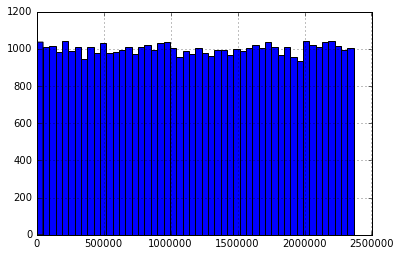

In [33]:
pd.Series(train_num.index).hist(bins=50)

In [41]:
train_num[train_num['Response']==1].index

Int64Index([   5179,    9368,   11575,   11864,   33821,   40151,   41146,
              41865,   44375,   49474,
            ...
            2309182, 2318356, 2322537, 2329368, 2334586, 2335395, 2346379,
            2346429, 2348808, 2355356],
           dtype='int64', name=u'Id', length=294)

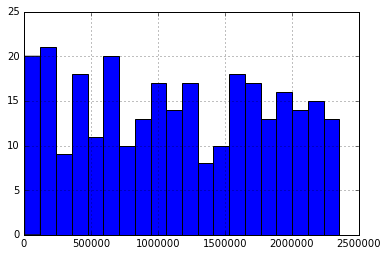

In [40]:
pd.Series(train_num[train_num['Response']==1].index).hist(bins=20)

In [43]:
combo = pd.merge(train_num, train_dat, how='left', left_index=True, right_index=True)

In [46]:
sorted_combo = combo.sort('L0_S0_D1')

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [49]:
sorted_combo.head(20)

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
Id,,,,,,,,,,,,,,,,,,,,,
823623,-0.219,-0.243,0.385,0.384,-0.013,-0.066,0.037,0.168,0.051,-0.115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750490,-0.193,-0.258,0.348,0.348,0.031,-0.066,0.030,0.208,-0.016,-0.030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640276,-0.206,-0.235,0.330,0.366,0.074,-0.021,0.030,0.168,-0.123,-0.104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1264014,-0.127,-0.213,0.348,0.348,0.074,-0.021,0.022,0.128,-0.102,-0.062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441961,-0.147,-0.183,0.330,0.348,0.031,-0.021,0.022,0.128,-0.046,-0.078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401128,-0.127,-0.198,0.385,0.330,-0.013,0.025,0.015,0.128,-0.082,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320578,-0.114,-0.198,0.385,0.366,-0.013,-0.021,0.015,0.128,0.036,-0.019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443268,-0.160,-0.198,0.348,0.348,-0.013,-0.066,0.022,0.128,0.102,-0.115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877334,-0.127,-0.175,0.367,0.312,-0.056,-0.066,0.015,0.128,0.076,-0.088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


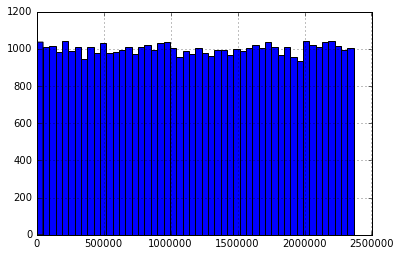

In [47]:
pd.Series(sorted_combo.index).hist(bins=50)

#### load the regular data

In [ ]:
'''
nrows = 50000
## select all the numerical columns and try to use LR
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),    index_col='Id', nrows = nrows)
train_dat = pd.read_csv(join(data_path, train_date_file),   index_col='Id', nrows = nrows)
train_cat = pd.read_csv(join(data_path, train_cat_file),    index_col='Id', nrows = nrows)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))
print train_dat.shape, train_num.shape, train_cat.shape
'''

In [12]:
tmp_train_num = train_num
tmp_train_dat = train_dat
tmp_train_cat = train_cat
#tmp_train_num = train_num.copy()
#tmp_train_dat = train_dat.copy()
#tmp_train_cat = train_cat.copy()

### stat processing categorical features

In [13]:

def BasicCat_FeatureEngineering(train_cat):
    ## feature engineering on the date features
    encoder = preprocessing.LabelEncoder()
    column_names = train_cat.columns.tolist()
    column_names.append('NaN')
    encoder.fit(column_names)
    dat_new_fea = pd.DataFrame()
    dat_new_fea['cat_sum'] = train_cat.sum(axis=1)
    dat_new_fea['cat_mean'] = train_cat.mean(axis=1)
    dat_new_fea['cat_nan_count'] = train_cat.isnull().sum(axis=1)
    dat_new_fea['cat_max'] = train_cat.max(axis=1)
    dat_new_fea['cat_min'] = train_cat.min(axis=1)
    dat_new_fea['cat_max_min_diff'] = dat_new_fea['cat_max'] - dat_new_fea['cat_min']
    dat_new_fea['cat_max_min_ratio'] = dat_new_fea['cat_min'] / dat_new_fea['cat_max']

    dat_new_fea['cat_idxmax'] = train_cat.idxmax(axis=1)
    dat_new_fea['cag_idxmax'].fillna('NaN', inplace=True)
    dat_new_fea['cat_idxmax'] = encoder.transform(dat_new_fea['cat_idxmax'])
    dat_new_fea['cat_idxmin'] = train_cat.idxmin(axis=1)
    dat_new_fea['cat_idxmin'].fillna('NaN', inplace=True)
    dat_new_fea['cat_idxmin'] = encoder.transform(dat_new_fea['cat_idxmin'])
    return dat_new_fea

In [14]:
remove_single_value_columns(tmp_train_cat)
remove_single_value_columns(tmp_train_num)
remove_single_value_columns(tmp_train_dat)

raw train data dimension:  (50000, 2140)
processed train data dimension:  (50000, 705)
raw train data dimension:  (50000, 969)
processed train data dimension:  (50000, 780)
raw train data dimension:  (50000, 1156)
processed train data dimension:  (50000, 931)


#### collect all the unique levels from categorical features and transform data by each level

In [15]:
unique_value_set = set()
for col in tmp_train_cat.columns:
    uniques = tmp_train_cat[col].dropna().unique()
    unique_value_set |= set(uniques)
    
level_mapping_dict = {}
for i, value in enumerate(sorted(list(unique_value_set))):
    level_mapping_dict[value] = i + 1

In [16]:
sorted_level_list = list(unique_value_set)
sorted_level_list = sorted(sorted_level_list)

In [17]:
## generic function to encode categorical features
def sweep_up_categorical_encode_by_dep_var(df, fea_name, test_df = None, dep_var_name='Response', count_thres = 10, nan_fill = -1., const_scale = 1.):
    tmp_df = df[[fea_name, dep_var_name]]
    tmp_df = tmp_df.fillna(nan_fill)
    value_counts = tmp_df[fea_name].value_counts()
    minor_keys = []
    key_dep_var_map = {}
    
    ## training sweep-up
    for counts, key in zip(value_counts.values, value_counts.index):
        if counts > count_thres:
            mean_dep_var = const_scale * tmp_df.loc[tmp_df[fea_name] == key, dep_var_name].mean()
            key_dep_var_map[key] = mean_dep_var
        else:
            minor_keys.append(key)
            
    ## mean value of dep_var for all the minor levels
    if len(minor_keys) > 0:
        minor_key_dep_var_mean = const_scale * tmp_df.loc[tmp_df[fea_name].isin(minor_keys), dep_var_name].mean()
        ## update the key_dep_var_map with minor key
        for key in minor_keys:
            key_dep_var_map[key] = minor_key_dep_var_mean
    
    encoded_train = tmp_df[fea_name].replace(key_dep_var_map)
    overall_mean_dep_var = tmp_df[dep_var_name].mean()
    
    ## sweep up the test column
    if test_df is not None:
        test_value_counts = test_df[fea_name].value_counts()
        test_minor_keys = []
        test_key_dep_var_map = key_dep_var_map.copy()
    
        for counts, key in zip(test_value_counts.values, test_value_counts.index):
            if key not in test_key_dep_var_map:
                print 'new level {} with counts {} found in test data'.format(key, counts)
                if counts > count_thres:
                    print 'warning! new level {} is found in test data!'.format(key)
                else:
                    test_minor_keys.append(key)
        
        if len(test_minor_keys) > 0:
            for key in test_minor_keys:
                test_key_dep_var_map[key] = const_scale * overall_mean_dep_var
        
        encoded_test = test_df[fea_name].replace(test_key_dep_var_map)
        return encoded_train, encoded_test
    
    else:
        return encoded_train
    
    
    

def getCat_LevelFeatures(series):
    feature_array = []
    tmp_series = series.dropna()
    for level in sorted_level_list:
        if sum(tmp_series.isin([level])):
            level_index = tmp_series[tmp_series == level].index
            feature_array.extend([level_index[0], level_index[-1], len(level_index)])
        else:
            feature_array.extend(['NaN', 'NaN', 0])
    return pd.Series(feature_array)       
    #print series.value_counts()       
    value_counts = series.value_counts()

    
start_time = time.time()

levelFeatures = tmp_train_cat.apply(getCat_LevelFeatures, axis=1)

print 'finish categorical feature engineering date using {} minutes'.format(round((time.time() - start_time)/60., 2))

finish categorical feature engineering date using 7.86 minutes


In [18]:
#sorted_level_list
column_name_features = []
cat_fea_names = []
for level in sorted_level_list:
    cat_fea_names.extend(['level_{}_start_column'.format(level), 
                          'level_{}_end_column'.format(level), 
                          'level_{}_column_counts'.format(level)])
    
    column_name_features.extend(['level_{}_start_column'.format(level), 
                                 'level_{}_end_column'.format(level)])

In [19]:
levelFeatures.columns = cat_fea_names

encoder = preprocessing.LabelEncoder()
column_names = train_cat.columns.tolist()
column_names.append('NaN')
encoder.fit(column_names)

for col in column_name_features:
    levelFeatures[col] = encoder.transform(levelFeatures[col]) 

In [20]:
## One-Hot encode important categorical columns
print tmp_train_cat.shape
imp_cat_fea = ['L3_S29_F3317', 'L3_S35_F3907', 'L3_S49_F4217', 'L3_S35_F3902', 'L3_S32_F3851', 'L3_S32_F3854']
cat_fea = []
for col in imp_cat_fea:
    if col in tmp_train_cat.columns:
        cat_fea.append(col)

imp_cat_df = tmp_train_cat[cat_fea].astype(str)
oneHot_combined_cat = pd.get_dummies(imp_cat_df, dummy_na=True)
tmp_train_cat = tmp_train_cat.ix[:, ~tmp_train_cat.columns.isin(imp_cat_fea)]
print tmp_train_cat.shape

(50000, 705)
(50000, 700)


In [21]:
print oneHot_combined_cat.shape

(50000, 30)


In [24]:
#levelFeatures.head()

,level_-2147483648.0_start_column,level_-2147483648.0_end_column,level_-2147483648.0_column_counts,level_-2147482688.0_start_column,level_-2147482688.0_end_column,level_-2147482688.0_column_counts,level_-2147482432.0_start_column,level_-2147482432.0_end_column,level_-2147482432.0_column_counts,level_-2147481664.0_start_column,...,level_16777248.0_column_counts,level_16777557.0_start_column,level_16777557.0_end_column,level_16777557.0_column_counts,level_33554448.0_start_column,level_33554448.0_end_column,level_33554448.0_column_counts,level_134217728.0_start_column,level_134217728.0_end_column,level_134217728.0_column_counts
Id,,,,,,,,,,,,,,,,,,,,,
26,705,705,NaN,705,705,NaN,705,705,NaN,705,...,NaN,705,705,NaN,705,705,NaN,705,705,NaN
49,705,705,NaN,705,705,NaN,705,705,NaN,705,...,NaN,705,705,NaN,705,705,NaN,705,705,NaN
56,705,705,NaN,705,705,NaN,705,705,NaN,705,...,NaN,705,705,NaN,705,705,NaN,705,705,NaN
86,705,705,NaN,705,705,NaN,705,705,NaN,705,...,NaN,705,705,NaN,705,705,NaN,705,705,NaN
93,705,705,NaN,705,705,NaN,705,705,NaN,705,...,NaN,705,705,NaN,705,705,NaN,705,705,NaN


In [48]:
## fill up the NaN in categorical data with 0.
tmp_train_cat = tmp_train_cat.fillna(0.)

In [43]:
#levelFeatures = levelFeatures.fillna(0)

In [ ]:
'''
print levelFeatures.shape
levelFeatures.head()

print tmp_train_cat.shape
tmp_train_cat.head()
'''

In [50]:
combined_train_cat = pd.concat([tmp_train_cat, oneHot_combined_cat, levelFeatures], axis=1)

In [51]:
print combined_train_cat.shape

(50000, 826)


### functions to process numerical and date features

In [72]:


def BasicDate_FeatureEngineering(tmp_train_dat):
    ## feature engineering on the date features
    encoder = preprocessing.LabelEncoder()
    column_names = tmp_train_dat.columns.tolist()
    column_names.append('NaN')
    encoder.fit(column_names)
    dat_new_fea = pd.DataFrame()
    dat_new_fea['start_time'] = tmp_train_dat['L0_S0_D1']
    dat_new_fea['time_sum'] = tmp_train_dat.sum(axis=1)
    dat_new_fea['time_mean'] = tmp_train_dat.mean(axis=1)
    dat_new_fea['dat_nan_count'] = tmp_train_dat.isnull().sum(axis=1)
    dat_new_fea['max_time'] = tmp_train_dat.max(axis=1)
    dat_new_fea['min_time'] = tmp_train_dat.min(axis=1)
    dat_new_fea['dat_max_min_diff'] = dat_new_fea['max_time'] - dat_new_fea['min_time']
    dat_new_fea['dat_max_min_ratio'] = dat_new_fea['min_time'] / dat_new_fea['max_time']

    dat_new_fea['dat_idxmax'] = tmp_train_dat.idxmax(axis=1)
    dat_new_fea['dat_idxmax'].fillna('NaN', inplace=True)
    dat_new_fea['dat_idxmax'] = encoder.transform(dat_new_fea['dat_idxmax'])
    dat_new_fea['dat_idxmin'] = tmp_train_dat.idxmin(axis=1)
    dat_new_fea['dat_idxmin'].fillna('NaN', inplace=True)
    dat_new_fea['dat_idxmin'] = encoder.transform(dat_new_fea['dat_idxmin'])
    return dat_new_fea


def getRelativeTimeColumns(series):
    '''
    normalize the time features by
    the start_time, the first none-NaN
    value
    '''
    if series[0] == np.NaN:
        start_time = series.dropna().index[0]
    else:
        start_time = series[0]
    new_series = series - start_time
    return new_series
   


def getTimeSteps(series, unique_value_counts = 10):
    '''
    in each row/series, use the sorted value_count
    to find the time steps and use the value, counts
    and column_index as features
    '''
    value_counts = series.value_counts()
    value_counts.sort_index(inplace=True)

    if 0. in value_counts.index:
        value_counts = value_counts[value_counts.index != 0.]
        
    available_counts = value_counts.shape[0]
    feature_array = []
    for i in xrange(unique_value_counts):
        if i < available_counts:
            value = value_counts.index[i]
            counts = value_counts[value]
            first_index = series[series == value].index[0]
            avg_time_cost = value / counts
            feature = [value, counts, avg_time_cost, first_index]
        else:
            feature = [-1., 0., 0., 'NaN']
        feature_array.extend(feature)

    return pd.Series(feature_array)



def getTimeChangeColumns(series):
    start_time = series[0]
    tmp_series = series.dropna()
    if start_time == np.NaN:
        first_index    = tmp_series.index[0]
        last_index     = tmp_series.index[-1]
        first_id_value = tmp_series[first_index]
        last_id_value  = tmp_series[last_index]
        time_diff      = last_id_value - first_id_value
        return pd.Series([first_index, last_index, time_diff, first_id_value, last_id_value])
    else:
        if np.sum(tmp_series != start_time) == 0:
            return pd.Series([np.NaN, np.NaN, np.NaN])
        else:
            first_index    = tmp_series.index[tmp_series != start_time][0]
            last_index     = tmp_series.index[tmp_series != start_time][-1]
            first_id_value = series[first_index]
            last_id_value  = series[last_index]
            first_id_value = tmp_series[first_index]
            last_id_value  = tmp_series[last_index]
            time_diff      = last_id_value - first_id_value
            return pd.Series([first_index, last_index, time_diff, first_id_value, last_id_value])


        
def getNonNaN_ColumIndex(series):
    if series.notnull().sum() == 0:
        return pd.Series([np.NaN, np.NaN, np.NaN])
    else:
        first_id = series[series.notnull()].index[0]
        last_id = series[series.notnull()].index[-1]
        time_diff = series[last_id] - series[first_id]
        return pd.Series([first_id, last_id, time_diff, first_time_value, last_time_value])



    
    
    
    
def DateFeatureEngineering(series):
    '''
    combination of time difference features and none-NaN features    
    this method is faster than separating two functions
    '''
    ## time features
    start_time = series[0]
    tmp_series = series.dropna()
    if start_time == np.NaN:
        first_index = tmp_series.index[0]
        last_index  = tmp_series.index[-1]
        time_diff   = tmp_series[last_index] - tmp_series[first_index]
        time_fea    = np.array([first_index, last_index, time_diff])
    else:
        if np.sum(tmp_series != start_time) == 0:
            time_fea = np.array([np.NaN, np.NaN, np.NaN])
        else:
            first_index = tmp_series.index[tmp_series != start_time][0]
            last_index  = tmp_series.index[tmp_series != start_time][-1]
            time_diff   = tmp_series[last_index] - tmp_series[first_index]
            time_fea = np.array([first_index, last_index, time_diff])
    ## none-NaN features
    if series.notnull().sum() == 0:
        nan_fea = np.array([np.NaN, np.NaN, np.NaN])
    else:
        first_id  = tmp_series.index[0]
        last_id   = tmp_series.index[-1]
        time_diff = tmp_series[last_id] - tmp_series[first_id]
        nan_fea = np.array([first_id, last_id, time_diff])
         
    new_fea_row = np.concatenate([time_fea, nan_fea])
    return pd.Series(new_fea_row)

### start processing numerical features

In [53]:


def NumericalFeatureEngineering(df, col_ignore = ['Response']):
    tmp_df = df.loc[:, ~df.columns.isin(col_ignore)]
    new_fea_df = pd.DataFrame()
    encoder = preprocessing.LabelEncoder()
    column_names = tmp_df.columns.tolist()
    column_names.append('NaN')
    encoder.fit(column_names)
    
    new_fea_df['num_mean'] = tmp_df.mean(axis=1)
    
    new_fea_df['num_sum'] = tmp_df.sum(axis=1)
    #num_sum_max = new_fea_df['num_sum'].max()
    #new_fea_df['num_sum'].fillna(1.*int(num_sum_max - 5), inplace=True)
    new_fea_df['num_max'] = tmp_df.max(axis=1)
    #num_max_max = new_fea_df['num_max'].max()
    #new_fea_df['num_max'].fillna(1.*int(num_max_max + 1), inplace=True)
    new_fea_df['num_min'] = tmp_df.min(axis=1)
    #num_min_min = new_fea_df['num_min'].min()
    #new_fea_df['num_min'].fillna(1.*int(num_min_min - 1.), inplace=True)
    new_fea_df['num_max_min_ratio'] = new_fea_df['num_min'] / new_fea_df['num_max']
    new_fea_df['num_max_min_ratio'] = new_fea_df['num_max_min_ratio'].replace([np.inf, -np.inf], np.NaN)
    new_fea_df['num_nan_col_count'] = tmp_df.isnull().sum(axis=1)
    new_fea_df['num_reg_col_count'] = tmp_df.shape[1] - tmp_df.isnull().sum(axis=1)
    new_fea_df['num_idxmax'] = tmp_df.idxmax(axis=1)
    new_fea_df['num_idxmax'].fillna('NaN', inplace=True)
    new_fea_df['num_idxmax'] = encoder.transform(new_fea_df['num_idxmax'])
    new_fea_df['num_idxmin'] = tmp_df.idxmin(axis=1)
    new_fea_df['num_idxmin'].fillna('NaN', inplace=True)
    new_fea_df['num_idxmin'] = encoder.transform(new_fea_df['num_idxmin'])
    return new_fea_df


In [54]:
tmp_train_num_Basics = NumericalFeatureEngineering(tmp_train_num)

In [ ]:
#print tmp_train_num_Basics.min().min(), tmp_train_num_Basics.max().max()

#### fill up the NaN in numerical features with nan_fill_value

In [ ]:
#print tmp_train_num.max().max(), '\n', tmp_train_num.min().min()

In [64]:
## check the maximum in different columns
#sorted_index = tmp_train_num.max().argsort()
#tmp_train_num.max()[sorted_index[-10:]]

In [65]:
tmp_train_num.fillna(1., inplace=True)

In [66]:
combined_train_num = pd.concat([tmp_train_num, tmp_train_num_Basics], axis=1)

In [ ]:
#print combined_train_num.isnull().sum().sum()

### start processing date features

In [73]:
start_time = time.time()

## normalized date columns
tmp_train_dat_Norm = tmp_train_dat.apply(getRelativeTimeColumns, axis=1)
## basic features from tmp_train_dat
tmp_train_dat_Basics = BasicDate_FeatureEngineering(tmp_train_dat)

encoder = preprocessing.LabelEncoder()
column_names = tmp_train_dat.columns.tolist()
column_names.append('NaN')
encoder.fit(column_names)
    
#'''
tmp_train_dat_TimeDiff = tmp_train_dat.apply(getTimeChangeColumns, axis=1)
tmp_train_dat_TimeDiff.columns = ['time_diff_start_col', 'time_diff_end_col', 'time_diff_value', 
                                  'first_time_value', 'last_time_value']
                   
for column in ['time_diff_start_col', 'time_diff_end_col']:
    tmp_train_dat_TimeDiff[column].fillna('NaN', inplace=True)
    tmp_train_dat_TimeDiff[column] = encoder.transform(tmp_train_dat_TimeDiff[column])  
    
#'''


unique_value_counts = 10
timeStep_columnNames = []
column_name_columns = []
for i in xrange(unique_value_counts):
    timeStep_columnNames.extend(['time_diff_step_{}'.format(i), 'column_counts_step_{}'.format(i), 
                                 'time_cost_step_{}'.format(i), 'first_column_step_{}'.format(i)])
    column_name_columns.append('first_column_step_{}'.format(i))

tmp_train_dat_TimeStep = tmp_train_dat_Norm.apply(getTimeSteps, axis=1)
tmp_train_dat_TimeStep.columns = timeStep_columnNames
for column in column_name_columns:
    tmp_train_dat_TimeStep[column].fillna('NaN', inplace=True)
    tmp_train_dat_TimeStep[column] = encoder.transform(tmp_train_dat_TimeStep[column])
    

print 'finish feature engineering date using {} minutes'.format(round((time.time() - start_time)/60, 2))

finish feature engineering date using 11.57 minutes


In [77]:
tmp_train_dat_Norm.isnull().sum()

L0_S0_D1            0
L0_S0_D3            0
L0_S0_D5            0
L0_S0_D7            0
L0_S0_D9            0
L0_S0_D11           0
L0_S0_D13           0
L0_S0_D15           0
L0_S0_D17           0
L0_S0_D19           0
L0_S0_D21           0
L0_S0_D23           0
L0_S1_D26          54
L0_S1_D30          54
L0_S2_D34       24937
L0_S2_D38       24937
L0_S2_D42       24937
L0_S2_D46       24937
L0_S2_D50       24937
L0_S2_D54       24937
L0_S2_D58       24937
L0_S2_D62       24937
L0_S2_D66       24937
L0_S3_D70       25082
L0_S3_D74       25082
L0_S3_D78       25082
L0_S3_D82       25082
L0_S3_D86       25082
L0_S3_D90       25082
L0_S3_D94       25082
                ...  
L3_S47_D4175    49179
L3_S47_D4180    49179
L3_S47_D4185    49179
L3_S47_D4190    49179
L3_S48_D4194    49180
L3_S48_D4195    49180
L3_S48_D4197    49180
L3_S48_D4199    49180
L3_S48_D4201    49180
L3_S48_D4203    49180
L3_S48_D4205    49180
L3_S49_D4208    49596
L3_S49_D4213    49596
L3_S49_D4218    49596
L3_S49_D42

In [23]:
tmp_train_dat_TimeDiff.head()

,time_diff_start_col,time_diff_end_col,time_diff_value,first_time_value,last_time_value
Id,,,,,
26,58,839,1.16,1104.79,1105.95
49,58,839,1.81,675.87,677.68
56,40,839,3.91,886.19,890.10
86,50,839,4.20,922.91,927.11
93,60,839,1.50,1096.11,1097.61


In [ ]:
'''
print tmp_train_dat_Norm.shape
tmp_train_dat_Norm.head()

print tmp_train_dat_TimeStep.shape
tmp_train_dat_TimeStep.head()

print tmp_train_dat_TimeDiff.shape
tmp_train_dat_TimeDiff.head()

print tmp_train_dat_Basics.shape
tmp_train_dat_Basics.head()
'''

#### fill up NaN in the date features

In [78]:
tmp_train_dat_Norm.fillna(-1., inplace=True)

In [79]:
combined_train_dat = pd.concat([tmp_train_dat_Norm, tmp_train_dat_Basics, tmp_train_dat_TimeDiff, tmp_train_dat_TimeStep], axis=1)

In [81]:
#combined_train_dat.isnull().sum()

In [ ]:
#print combined_train_dat.max().max(), combined_train_dat.min().min()

In [ ]:
#combined_train_dat.fillna(nan_fill_value, inplace=True)

In [ ]:
#print combined_train_dat.isnull().sum().sum()

In [ ]:
#'start_time' in combined_train_dat

#### create features from index columns

In [97]:
combined_train_dat['first_time_index']         = combined_train_dat['first_time_value'].argsort() + 1
combined_train_dat['last_time_index']          = combined_train_dat['last_time_value'].argsort() + 1 
combined_train_dat['index_ratio']              = combined_train_dat['first_time_index'] / combined_train_dat['last_time_index']
combined_train_dat['start_time_index']         = combined_train_dat['start_time'].argsort() + 1
combined_train_dat['start_time_index_ratio_1'] = combined_train_dat['first_time_index'] / combined_train_dat['start_time_index']
combined_train_dat['start_time_index_ratio_2'] = combined_train_dat['last_time_index'] / combined_train_dat['start_time_index']
combined_train_dat['index']                    = combined_train_cat.index

In [26]:
combined_train_num['top_2_ratio'] = combined_train_num['L3_S33_F3859'] / combined_train_num['L3_S33_F3857']

'''
to_index_column_names = ['L0_S0_F20', 'L3_S33_F3859', 'L0_S1_F28', 'L3_S30_F3754', 'L3_S33_F3857',
                         'L0_S1_F24', 'L0_S2_F44', 'L3_S30_F3754', 'L3_S30_F3744']
for col in to_index_column_names:
    col_name = '{}_index'.format(col)
    combined_train_num[col_name] = combined_train_num[col].argsort()
    if col != to_index_column_names[0]:
        ratio_col_name = '{}_index_ratio'.format(col)
        bench_col_name = col_name = '{}_index'.format(to_index_column_names[0])
        combined_train_num[ratio_col_name] = combined_train_num[col] / combined_train_num[bench_col_name]
'''

"\nto_index_column_names = ['L0_S0_F20', 'L3_S33_F3859', 'L0_S1_F28', 'L3_S30_F3754', 'L3_S33_F3857',\n                         'L0_S1_F24', 'L0_S2_F44', 'L3_S30_F3754', 'L3_S30_F3744']\nfor col in to_index_column_names:\n    col_name = '{}_index'.format(col)\n    combined_train_num[col_name] = combined_train_num[col].argsort()\n    if col != to_index_column_names[0]:\n        ratio_col_name = '{}_index_ratio'.format(col)\n        bench_col_name = col_name = '{}_index'.format(to_index_column_names[0])\n        combined_train_num[ratio_col_name] = combined_train_num[col] / combined_train_num[bench_col_name]\n"

In [83]:
remove_single_value_columns(combined_train_num)
remove_single_value_columns(combined_train_dat)

raw train data dimension:  (50000, 789)
processed train data dimension:  (50000, 789)
raw train data dimension:  (50000, 993)
processed train data dimension:  (50000, 980)


### combine all the data together

In [103]:
combined_train = pd.concat([combined_train_num, combined_train_dat, combined_train_cat], axis=1)

In [104]:
spec_col = combined_train[['start_time_index_ratio_1', 'start_time_index_ratio_2']].apply(lambda x: sum(x.isin([np.inf, -np.inf])))

In [105]:
spec_col

start_time_index_ratio_1    0
start_time_index_ratio_2    0
dtype: int64

In [94]:
spec_col[spec_col != 0]

index_ratio                 1
start_time_index_ratio_1    1
start_time_index_ratio_2    1
dtype: int64

In [102]:
combined_train_dat['first_time_index'].min()

1

In [29]:
'start_time' in combined_train.columns

True

In [86]:
print combined_train.shape
combined_train.head()

(50000, 2595)


,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,level_16777248.0_column_counts,level_16777557.0_start_column,level_16777557.0_end_column,level_16777557.0_column_counts,level_33554448.0_start_column,level_33554448.0_end_column,level_33554448.0_column_counts,level_134217728.0_start_column,level_134217728.0_end_column,level_134217728.0_column_counts
Id,,,,,,,,,,,,,,,,,,,,,
26,0.016,0.093,-0.015,-0.016,0.031,0.116,-0.007,-0.072,0.209,0.035,...,0.0,705,705,0.0,705,705,0.0,705,705,0.0
49,0.088,0.033,0.330,0.348,-0.056,0.161,0.008,0.088,-0.112,0.008,...,0.0,705,705,0.0,705,705,0.0,705,705,0.0
56,0.003,0.056,-0.033,-0.034,-0.056,0.116,0.000,-0.072,0.056,0.045,...,0.0,705,705,0.0,705,705,0.0,705,705,0.0
86,-0.003,0.041,-0.033,-0.016,0.074,0.161,0.000,-0.072,0.025,-0.024,...,0.0,705,705,0.0,705,705,0.0,705,705,0.0
93,-0.029,-0.071,-0.015,0.003,0.031,0.116,0.008,0.088,0.071,0.083,...,0.0,705,705,0.0,705,705,0.0,705,705,0.0


In [239]:
#combined_train = combined_train_dat
#combined_train[dep_var_name] = combined_train_num[dep_var_name]

In [124]:
############## Section of regular validation #######################
train_index, valid_index = create_validation_index(combined_train, 0.3, dep_var_name, True)
valid_data = combined_train.ix[valid_index]
tmp_train  = combined_train.ix[train_index]

In [125]:
y = tmp_train[dep_var_name].values
X = tmp_train.drop(dep_var_name, axis=1)

valid_y = valid_data[dep_var_name].values
valid_X = valid_data.drop(dep_var_name, axis=1)

#### tree-base models

In [126]:
rf_params = {'random_state' : 9999, 'n_estimators' : 2000, 'max_depth' : 7, 'criterion' : 'gini', 'n_jobs' : -1}
et_params = {'random_state' : 9999, 'n_estimators' : 500, 'max_depth' : 8, 'criterion' : 'gini', 'n_jobs' : -1}
rf_clf = RandomForestClassifier(**rf_params)
rf_clf = rf_clf.fit(X, y)

et_clf = RandomForestClassifier(**et_params)
et_clf = et_clf.fit(X, y)

In [127]:
rf_pred = rf_clf.predict_proba(valid_X)[:, 1]
et_pred = et_clf.predict_proba(valid_X)[:, 1]

print 'result from using constant fraction: \n', score_MCC(valid_y, pred)
print '\n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_y, rf_pred), CombinedModel.mcc_eval_func(valid_y, et_pred)

result from using constant fraction: 
mean of groud truth: 0.00673378225215
threshold for preds: 0.0169038483449
-0.006779433481


result from using flexsible threshold: (0.16059995247485082, 0.10554372131336556) (0.15940669472622862, 0.0966805250669105)


#### Logistic Regression model

In [247]:
C = 0.1
start_time = time.time()
LR_clf = LogisticRegression(C = C, class_weight='balanced', n_jobs = -1, penalty='l2')
LR_clf.fit(X, y)
print 'finish training LR model using {} seconds'.format(round(time.time() - start_time, 0))

finish training LR model using 242.0 seconds


#### xgboost model

In [128]:
params = {}
params["eta"]                      = 0.0075
params["subsample"]                = 0.8
params["colsample_bytree"]         = 0.8
params["num_round"]                = 201
params["max_depth"]                = 20
params["gamma"]                    = 0
params["metrics"]                  = 'auc'
params['eval_metric']              = 'auc'
params["seed"]                     = 999
params['verbose_eval']             = 50
## whether to use weights
params['use_base_score']           = True
params['use_weights']              = True
#params['use_scale_pos_weight']     = True
params["val"]                      = False

model = xgboost_classifier(label_name = dep_var_name, params = params, model_file='bosch_xgb_model')
model.fit(tmp_train, dep_var_name)

scale_pos_weight: 146.06302521
a base_score 0.00679980571984 is used in the xgboost model...



####################
 train the xgboost without early stopping
####################


[0]	train-auc:0.868976
[50]	train-auc:0.994708
[100]	train-auc:0.996915
[150]	train-auc:0.998074
[200]	train-auc:0.99903
the xgboost fit is finished by using 237.490554094 seconds, saved into bosch_xgb_model


In [129]:
#pred = LR_clf.predict_proba(valid_X)[:, 1]
pred = model.predict(valid_X)

print 'result from using constant fraction: \n', score_MCC(valid_y, pred)
print '\n \n'
print 'result from using flexsible threshold:', CombinedModel.mcc_eval_func(valid_y, pred)

in the prediction step, dep_var_name is not provided....
result from using constant fraction: 
mean of groud truth: 0.00673378225215
threshold for preds: 0.0181400978378
0.132774151358

 

result from using flexsible threshold: (0.1643330196872456, 0.0278753861784935)
